# Example to perform causal discovery on data with discrete variables

This notebook explains how to perform causal discovery when exogenous, endogenous, and sink variables are assumed, as well as when discrete ordinal variables are included in the exogenous and sink variables.

Most algorithms implemented in lingam package can't be applied to data containing discrete variables. However, when discrete variables are included in exogenous or sink variables, it is possible to perform causal discovery by incorporating the ideas described in this notebook.

## Theory

#### Input and output

<div style="float:left;width:49%">
<ul>
<li>Input
    <ul><li>Data<ul><li>$ X = (X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8) $</li></ul></li></ul>
    <ul><li>Names of exogenous variables<ul><li>$ exog\_var\_names = (1, 2, 3) $</li></ul></li></ul>
    <ul><li>Names of endogenous variables<ul><li>$ endog\_var\_names = (4, 5, 6, 7) $</li></ul></li></ul>
    <ul><li>Name of sink variable<ul><li>$ sink\_var\_name =  8 $</li></ul></li></ul>
</li>
<li>Output
    <ul><li>An adjacency matrix representing the presence of directed causal edges between variables<ul><li>$ \hat{B} $</li></ul></li></ul>
</li>
</ul>
</div>

<div style="float:right;width:49%">
<img src="images/example_to_analyze_data_with_discrete_variables.png">
</div>

#### 1. Remove exogenous effects from X using linear regression

<div style="float:left;width:49%">
<ul>
<li>Input<ul>
    <li>Data on exogenous variables<ul><li>$ X_{exogenous} = (X_1, X_2, X_3) $</li></ul></li>
    <li>Data on endogenous variables<ul><li>$ X_{endogenous} = (X_4, X_5, X_6, X_7) $</li></ul></li>
</ul></li>
    
<li>Output<ul>
    <li>Data with exogenous effects removed<ul><li>$ X'_{exogenous} = (X'_4, X'_5, X'_6, X'_7) $</li></ul></li>
</ul></li>
</ul>
</div>

<div style="float:right;width:49%">
<img src="images/example_to_analyze_data_with_discrete_variables2.png" style="width:69%">
</div>

#### 2. Estimate adjacency matrix $ B' $ representing a causality of endogenous variables

<div style="float:left;width:49%">
<ul>   
<li>Input<ul>
    <li>Data with exogenous effects removed<ul><li>$ X'_{exogenous} = (X'_4, X'_5, X'_6, X'_7) $</li></ul></li>
</ul></li>
<li>Output<ul>
    <li>An adjacency matrix representing the presence of directed causal edges between endgeneous variables<ul><li>$ B' \quad such \, that \quad X'_{endogenous} = B' X'_{endogenous} + e' $</li>
</ul></li>
</ul>
</div>

<div style="float:right;width:49%">
<img src="images/example_to_analyze_data_with_discrete_variables3.png" style="width:69%">
</div>

#### 3. Estimate edges $ W $ from endogenous variables to the sink variable

<div style="float:left;width:49%">
<ul>   
<li>Input<ul>
    <li>Data on the sink variable<ul><li>$ X_{8} $</li></ul></li>
    <li>Data with exogenous effects removed<ul><li>$ X'_{exogenous} = (X'_4, X'_5, X'_6, X'_7) $</li></ul></li>
</ul></li>
<li>Output<ul>
    <li>A vector representing the presence of directed causal edges from exogenous and endogenous variables to sink variables<ul><li>$ W \; which \; elements \; represent \; coefficients \; of \; logistic \; regression $</li></ul></li>
</ul></li>
</ul>
</div>

<div style="float:right;width:49%">
<img src="images/example_to_analyze_data_with_discrete_variables4.png" style="width:69%">
</div>

#### 4. Create adjacency matrix $ \hat{B} $ by stacking $ B' $ and $ W $

<div style="float:left;width:49%">
<ul>
<li>Input<ul>
    <li>Adjacency matrix representing a causality on endogenous variables<ul><li>$ B' $</li></ul></li>
    <li>Coefficients from endogenous variables to the sink variable<ul><li>$ W $</li></ul></li>
</ul></li>

<li>Output<ul>
    <li>Adjacency matrix of interest in this analysis<ul><li>$ \hat{B} $ such that $ B' $ and $ W $ are stacked as follows: <br>
    <img src="images/example_to_analyze_data_with_discrete_variables5.png" style="width:40%">
    </li></ul></li>
</ul></li>
</ul>
</div>

<div style="float:right;width:49%">
<img src="images/example_to_analyze_data_with_discrete_variables4.png" style="width:69%">
</div>

## Preparation

### Import packages

In [1]:
import os
import shutil
import requests
import logging

import numpy as np
import pandas as pd
from scipy.special import expit
import semopy
import networkx as nx

from lingam import DirectLiNGAM
from lingam.utils import remove_effect
from lingam.utils import calculate_total_effect
from lingam.bootstrap import BootstrapResult
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.utils import check_array

from lingam.utils import make_dot
from lingam.utils import print_causal_directions
from lingam.utils import print_dagc
import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import display, Markdown

# versions
import scipy
import lingam
import sklearn
import matplotlib
for lib in [np, pd, scipy, semopy, nx, lingam, sklearn, matplotlib, gv]:
    print(lib.__name__, lib.__version__)

numpy 1.24.4
pandas 2.0.3
scipy 1.10.1
semopy 2.3.9
networkx 3.1
lingam 1.9.1
sklearn 1.3.2
matplotlib 3.7.5
graphviz 0.20.3


### Configure

In [2]:
np.random.seed(0)

In [3]:
logging.disable()

### Download source code

To run this notebook, you need to download and set up the source code for [ada_logistic_reg](https://github.com/cdt15/ada_logistic_reg). The source code can be downloaded and imported by executing the code below, but the R and glmnet packages must be installed manually.

In [4]:
def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w") as f:
        f.write(res.text)

# destinaiton of downloaded source code
dirname = "ada_log_reg"
if os.path.isdir(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)

# download required source code
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/_adaptive_logistic_regression.py", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/adaptive_logistic_regression.r", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/__init__.py", dirname=dirname)

from ada_log_reg import predict_adaptive_logistic_regression

# check that dounwloaded source code works properly
try:
    X = np.random.uniform(size=(2, 100))
    y = expit(2 * X[0] - X[1]) >= np.random.uniform(size=100)
    X = np.vstack([X, y]).T
    predict_adaptive_logistic_regression(X, [0, 1], 2)
except:
    raise RuntimeError("Check that the R and glmnet packages are installed and that the path to the Rscript is set correctly.")

# define an interface like scikit-learn
class AdaptiveLogisticRegression:

    def fit(self, X, y):
        X = check_array(X)
        y = check_array(y, ensure_2d=False, dtype=int)
        
        X_ = np.concatenate([X, y.reshape(-1, 1)], axis=1)
        
        predictors = np.arange(len(X.T))
        target = X_.shape[1] - 1
        
        coef = predict_adaptive_logistic_regression(X_, predictors, target)
        
        self.coef_ = coef

## Test data

### Adjacency matrix

In [5]:
m = np.array([
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 1.043, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 1.727, 0.537, 0.000, 0.000, 0.000, 0.000, 0.000],
    [1.041, 0.000, 0.000, 0.427, 0.911, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 1.960, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.883, 1.385, 0.000],
])

names = [f"x{i + 1}" for i in range(len(m))]
m = pd.DataFrame(m, columns=names, index=names)

m

,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x4,0.000,1.043,0.000,0.000,0.000,0.000,0.000,0.0
x5,0.000,1.727,0.537,0.000,0.000,0.000,0.000,0.0
x6,1.041,0.000,0.000,0.427,0.911,0.000,0.000,0.0
x7,0.000,0.000,0.000,1.960,0.000,0.000,0.000,0.0
x8,0.000,0.000,0.000,0.000,0.000,0.883,1.385,0.0


This adjacency matrix is drawn as a following causal graph:

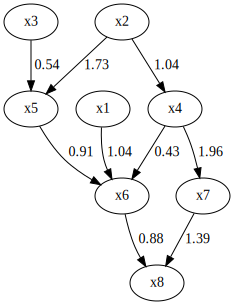

In [6]:
make_dot(m, lower_limit=0, labels=m.columns.tolist())

### Generate test data

A test data is generated according to the adjacency matrix and x1 and x7 are generated as discrete variables. The values of that discrete variables are 0 or 1.

In [7]:
# settings
n_sample = 1000
discrete_indices = [0, 7]

# initialize
X = np.zeros((len(m), n_sample))

# generate test data according to m
for i in range(len(m)):
    if i not in discrete_indices:
        X[i] = m.iloc[i] @ X + np.random.uniform(-1.732, 1.732, size=n_sample)
    else:
        X[i] = (expit(m.iloc[i] @ X) >= np.random.uniform(0, 1, size=n_sample)).astype(int)
X = pd.DataFrame(X.T, columns=names)

# convert types of continuous variables to float, types of discrete variables to int
dtypes = {}
for i, name in enumerate(names):
    dtypes[name] = int if i in discrete_indices else float
X = X.astype(dtypes)

Histograms of test data are as follows:

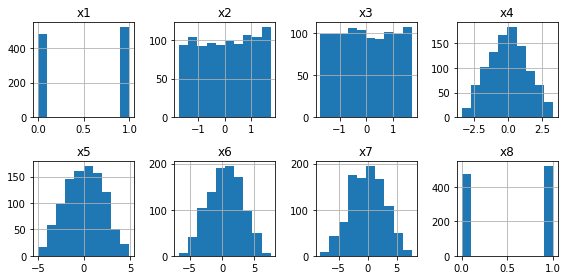

In [8]:
X.hist(layout=(2, 4), figsize=(8, 4))
plt.tight_layout()
plt.show()

Types of test data are as follows:

In [9]:
X.dtypes

x1      int64
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7    float64
x8      int64
dtype: object

## Analysis

This chapter conduts how to perform causal discovery to data including discrete variables.

### Classify test data variables into three subsets

We classify test data variables into three subsets: exogenous variables, endogenous variables, and sink variables.

In [10]:
exog_var_names = ["x1", "x2", "x3"]
endog_var_names = ["x4", "x5", "x6", "x7"]
sink_var_name = "x8"

The causal graph is as follows:

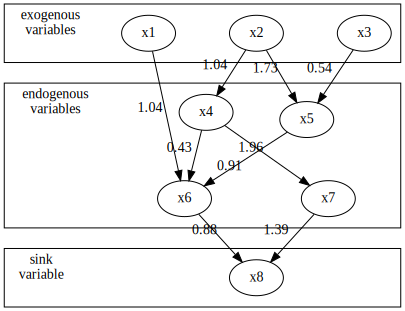

In [11]:
g = gv.Digraph(engine="neato", graph_attr={"splines":"true"})

cluster_names = ["exogenous", "endogenous", "sink"]

node_kws = {
    "x1": {"pos": "0,0!"},
    "x2": {"pos": "1.5,0!"},
    "x3": {"pos": "3.0,0!"},
    "x4": {"pos": "0.8,-1.1!"},
    "x5": {"pos": "2.2,-1.2!"},
    "x6": {"pos": "0.5,-2.3!"},
    "x7": {"pos": "2.5,-2.3!"},
    "x8": {"pos": "1.5,-3.4!"},
}

dummy_node_kws = {
    "exogenous": [
        {"pos":"-2,0.4!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        {"pos":"3.5,-0.4!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
    ],
    "endogenous": [
        {"pos":"-2,-0.7!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        {"pos":"3.5,-2.7!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
    ],
    "sink": [
        {"pos":"-2,-3.0!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        {"pos":"3.5,-3.8!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
    ]
}

# add nodes
for cluster_name, var_names in zip(cluster_names, [exog_var_names, endog_var_names, [sink_var_name]]):
    # make subgraph
    with g.subgraph(name=f"cluster_{cluster_name}", graph_attr={"margin":"4,4!"}) as sub:
        for var_name in var_names:
            kw = {} if var_name not in node_kws.keys() else node_kws[var_name]
            sub.node(var_name, var_name, **kw)
        s = "" if cluster_name == "sink" else "s"
        sub.attr(label=f"{cluster_name}\nvariable" + s, labeljust="l")
        
        # dummies
        sub.node(cluster_name + "_lu", "", **dummy_node_kws[cluster_name][0])
        sub.node(cluster_name + "_rl", "", **dummy_node_kws[cluster_name][1])

# add edges
for to_name, coefs in m.iterrows():
    for from_name, coef in coefs.items():
        if np.isclose(coef, 0):
            continue
        
        g.edge(from_name, to_name, label=f"{coef:.2f}")

g

### Perform causal discovery

A causal discovery is performed with test data X and three subsets of variable names to analyze a causal relation of endogenous variables and sink variable. First, we remove effects of exogenous variables from test data X.

In [12]:
X_removed_exog = X.copy()

# remove effects of exogenous variables from X by regression
for endog_var_name in endog_var_names:
    # fitting a linear regression model
    reg = LinearRegression()
    reg.fit(X[exog_var_names], X[endog_var_name])
    
    # remove effects of exogenous variables from other variables
    X_removed_exog[endog_var_name] = X[endog_var_name] - reg.predict(X[exog_var_names])

X_removed_exog = X_removed_exog.drop(exog_var_names, axis=1)

We performs causal discovery with test data removed effects of exogenous variables.

In [13]:
cd_model = DirectLiNGAM()
cd_model.fit(X_removed_exog[endog_var_names])

cd_model.adjacency_matrix_

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.3985687 , 0.90487899, 0.        , 0.        ],
       [1.93148696, 0.        , 0.        , 0.        ]])

Next, we estimate a model for the sink variable using the endogenous variables as explanatory variables. Since the sink variable is a discrete variable, a logistic regression model is used.

In [14]:
sink_model = LogisticRegression(penalty=None)
sink_model.fit(X_removed_exog[endog_var_names], X_removed_exog[sink_var_name])

sink_model.coef_

array([[-0.01997552, -0.07101336,  0.33328635,  0.40071051]])

The adjacency matrix of the endogenous variables and the coefficients of the model of the sink variable are combined into one adjacency matrix to obtain the results of the analysis.

In [15]:
adj = np.concatenate([cd_model.adjacency_matrix_, sink_model.coef_])
adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

cols = endog_var_names + [sink_var_name]
adj = pd.DataFrame(adj, columns=cols, index=cols)

adj

,x4,x5,x6,x7,x8
x4,0.000000,0.000000,0.000000,0.000000,0.0
x5,0.000000,0.000000,0.000000,0.000000,0.0
x6,0.398569,0.904879,0.000000,0.000000,0.0
x7,1.931487,0.000000,0.000000,0.000000,0.0
x8,-0.019976,-0.071013,0.333286,0.400711,0.0


### Visualize a result

The causal graph is as follows:

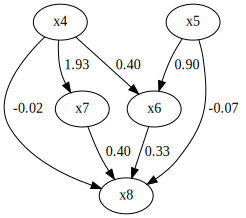

In [16]:
make_dot(adj, labels=adj.columns.tolist(), lower_limit=0.0)

### Evaluation by fitting indices

The estimated results are considered as a SEM model and the fitting indices is calculated.

In [17]:
def calc_fit_indices(B, X, sink_var_name):
    """ calculate fitting indices with adjacency matrix B and data X """
    
    desc = ""
    for name, row in B.iterrows():
        var_model = []
        
        for name2, coef in row.items():
            if np.isclose(coef, 0):
                continue
            var_model.append(f"{coef} * {name2}")
        
        if len(var_model) == 0:
            continue
        
        var_model = f"{name} ~ " + " + ".join(var_model) + "\n"
        desc += var_model
    
    desc += "DEFINE(ordinal) " + str(sink_var_name)
    
    m = semopy.Model(desc)
    m.fit(X)
    stats = semopy.calc_stats(m)
    
    return stats

X_eval = X_removed_exog.copy()
X_eval[sink_var_name] = X[sink_var_name]

fit_indices = calc_fit_indices(adj, X_eval, sink_var_name)
fit_indices

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,12,12,5144.605986,0.0,6225.048346,0.173899,0.173564,0.173564,0.173564,0.173899,0.654328,-4.289212,10.434054,5.144606


### Prune the model for the sink variable

Comparing the estimated results with the true causal graph, we can see that extra edges toward x7 are estimated. Using AdaptiveLogisticRegression instead of LogsticRegression as the model for the sink variable solves this problem.

In [18]:
sink_model2 = AdaptiveLogisticRegression()
sink_model2.fit(X_removed_exog[endog_var_names], X_removed_exog[sink_var_name])

sink_model2.coef_

array([[0.        , 0.        , 0.28666118, 0.39344918]])

As before, the adjacency matrix of the endogenous variables and the coefficients of the model of the sink variable are made into one adjacency matrix.

In [19]:
adj = np.concatenate([cd_model.adjacency_matrix_, sink_model2.coef_])
adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

cols = endog_var_names + [sink_var_name]
adj = pd.DataFrame(adj, columns=cols, index=cols)

adj

,x4,x5,x6,x7,x8
x4,0.000000,0.000000,0.000000,0.000000,0.0
x5,0.000000,0.000000,0.000000,0.000000,0.0
x6,0.398569,0.904879,0.000000,0.000000,0.0
x7,1.931487,0.000000,0.000000,0.000000,0.0
x8,0.000000,0.000000,0.286661,0.393449,0.0


The causal graph is as follows:

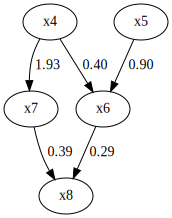

In [20]:
make_dot(adj, labels=adj.columns.tolist(), lower_limit=0.0)

By comparing it to the true causal graph, we can see that the extra edge is no longer estimated.

Fitting indices is as follows:

In [21]:
fit_indices2 = calc_fit_indices(adj, X_eval, sink_var_name)
fit_indices2

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,12,12,5180.221832,0.0,6225.048346,0.168166,0.167842,0.167842,0.167842,0.168166,0.656594,-4.360444,10.362822,5.180222


## Analysis with bootstrapping

We perform the same analysis as before with bootstrapping. First, combine the previous analysis into a single function, the run_analysis function, as follows

In [22]:
def run_analysis(X, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=None):
    """
    X : pandas.DataFrame
        That data type must be float or int. Variables of type int are interpreted as discrete.
    exog_var_names : list of str
        List of names of exogenous variables.
    endog_var_names : list of str
        List of names of endogenous variables.
    sink_var_name : str
        Name of the sink variable.
    cd_model : object
        Instance of LiNGAM model.
    sink_model : object
        Instance of a model for the sink variable.
    """
    # check X
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be padnas.DataFrame.")
    
    # check lists of variable names
    if len(set(exog_var_names) - set(X.columns)) > 0:
        raise ValueError("exog_var_names includes unknown variables.")
       
    if len(set(endog_var_names) - set(X.columns)) > 0:
        raise ValueError("endog_var_names includes unknown variables.")
        
    if len(set([sink_var_name]) - set(X.columns)) > 0:
        raise ValueError("sink_var_name is unknown variables.")

    # check cd_model
    if cd_model is None:
        cd_model = DirectLiNGAM()
    else:
        if isinstance(cd_model, DirectLiNGAM):
            pass
        else:
            # other models aren't supported.
            raise ValueError("Unsupported cd_model")
    
    # preprocess X
    exog_indices = [X.columns.tolist().index(v) for v in exog_var_names]
    endog_indices = [X.columns.tolist().index(v) for v in endog_var_names]
    sink_index = X.columns.tolist().index(sink_var_name)
    
    is_discrete = X.dtypes == int
    if is_discrete[endog_indices].any():
        raise ValueError("endog_var_names mustn't be a discrete variable. Convert types of variables specified in endog_var_names.")
    
    names = X.columns.tolist()
    
    X = check_array(X, copy=True)
    
    if sink_model is None:
        if is_discrete[sink_index]:
            sink_model = LogisticRegression()
        else:
            sink_model = LinearRegression()
    
    # perform causal discovery
    X_removed_exog = remove_effect(X, exog_indices)
    X_endog = X_removed_exog[:, endog_indices]
    
    cd_model.fit(X_endog)
    
    # model for the given sink variable
    sink_model.fit(X[:, endog_indices], X[:, sink_index])
    sink_coef = sink_model.coef_

    # make adjacency matrix for endogenous variabels and a sink variable
    adj = np.concatenate([cd_model.adjacency_matrix_, sink_coef])
    adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

    cols = [names[i] for i in [*endog_indices, sink_index]]
    adj = pd.DataFrame(adj, columns=cols, index=cols)
    
    return adj

### Perform bootstrapping

In [23]:
# number of bootstrapping
n_sampling = 100

# number of features
n_features = len(endog_var_names) + len([sink_var_name])

# container of a result
adjs = np.zeros((n_sampling, n_features, n_features))
total_effects = np.zeros((n_sampling, n_features, n_features))
fit_indices_df = []

# perform bootstrapping
for i in range(n_sampling):
    print("\r", i, end="")
    
    X_resampled = resample(X)
    
    # causal discovery on endogenous variabels and a sink variable
    adj = run_analysis(
        X_resampled,
        exog_var_names,
        endog_var_names,
        sink_var_name,
        sink_model=AdaptiveLogisticRegression()
    )
    adjs[i] = adj

    # calc causal order
    dag = nx.from_numpy_array(adj.values.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(dag))

    # calc causal effects
    for c, from_ in enumerate(causal_order):
        for to in causal_order[c + 1 :]:
            total_effects[i, to, from_] = calculate_total_effect(
                adj.values, from_, to
            )
    
    fit_indices = calc_fit_indices(adj, X_resampled, sink_var_name)
    fit_indices_df.append(fit_indices)
print("\r\n")

# store results
result = BootstrapResult(adjs, total_effects)

fit_indices_df = pd.concat(fit_indices_df)

 99



### Confirm results of a bootstrapping

For more information on verifying bootstrap results, refer to [this notebook](https://github.com/cdt15/lingam/blob/master/examples/Bootstrap.ipynb).

### Causal Directions

In [24]:
# variable names of an estimated adjacency matrix
var_names = X_removed_exog.columns.tolist() + [sink_var_name]

cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling, labels=var_names)

x6 <--- x4 (b>0) (100.0%)
x6 <--- x5 (b>0) (100.0%)
x7 <--- x4 (b>0) (100.0%)
x8 <--- x6 (b>0) (100.0%)
x8 <--- x7 (b>0) (100.0%)
x8 <--- x5 (b<0) (9.0%)
x8 <--- x4 (b>0) (2.0%)
x7 <--- x5 (b<0) (1.0%)


### Directed Acyclic Graphs

In [25]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling, labels=var_names)

DAG[0]: 89.0%
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x4 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[1]: 8.0%
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x4 (b>0)
	x8 <--- x5 (b<0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[2]: 2.0%
	x6 <--- x4 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x4 (b>0)
	x8 <--- x4 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)


### Bootstrap probability

In [26]:
prob = result.get_probabilities(min_causal_effect=0.01)
prob

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.01, 0.  , 0.  , 0.  ],
       [0.02, 0.09, 1.  , 1.  , 0.  ]])

### Total Causal Effects

In [27]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

df = pd.DataFrame(causal_effects)
df['from'] = df['from'].apply(lambda x : var_names[x])
df['to'] = df['to'].apply(lambda x : var_names[x])
display(df)

,from,to,effect,probability
0,x4,x6,0.404978,1.00
1,x5,x6,0.912974,1.00
2,x4,x7,1.932310,1.00
3,x4,x8,2.929688,1.00
4,x5,x8,0.815726,1.00
5,x6,x8,0.911478,1.00
6,x7,x8,1.327679,1.00
7,x5,x7,-0.082208,0.01


### Bootstrap Probability of Path

In [28]:
from_var_name = "x4"
to_var_name = "x8"
display(Markdown(f"#### {from_var_name}→{to_var_name}"))

path = result.get_paths(var_names.index(from_var_name), var_names.index(to_var_name))
path = pd.DataFrame(path)

path["path"] = path["path"].apply(lambda indices: [var_names[i] for i in indices])

path

#### x4→x8

,path,effect,probability
0,"[x4, x6, x8]",0.370823,1.00
1,"[x4, x7, x8]",2.539992,1.00
2,"[x4, x8]",0.757541,0.02
